<h1><center>Лабораторна робота 2.</center></h1>
<h2><center>Візуальний аналіз даних серцево-судинних захворювань</center></h2>

**Виконав:** Прізвище І.П.

**Варіант:** №__

У лабораторній роботі №2 вам потрібно дати відповідь на кілька запитань щодо набору даних про серцево-судинні захворювання.

#### Опис задачі

Виконайте візуальний аналіз даних та зробіть прогноз на його основі наявності або відсутності серцево-судинних захворювань (ССЗ) за результатами обстеження пацієнта.

#### Опис даних

Є 3 типи вхідних ознак:

- *Об'єктивна інформація*: фактична інформація про пацієнта;
- *Огляд*: результати медичного огляду;
- *Суб'єктивна інформація*: інформація, надана пацієнтом.

| Feature                                       | Variable Type       | Variable    | Value Type                                       |
|-----------------------------------------------|---------------------|-------------|--------------------------------------------------|
| Age                                           | Objective Feature   | age         | int (days)                                       |
| Height                                        | Objective Feature   | height      | int (cm)                                         |
| Weight                                        | Objective Feature   | weight      | float (kg)                                       |
| Gender                                        | Objective Feature   | gender      | categorical code                                 |
| Systolic blood pressure                       | Examination Feature | ap_hi       | int                                              |
| Diastolic blood pressure                      | Examination Feature | ap_lo       | int                                              |
| Cholesterol                                   | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose                                       | Examination Feature | gluc        | 1: normal, 2: above normal, 3: well above normal |
| Smoking                                       | Subjective Feature  | smoke       | binary                                           |
| Alcohol intake                                | Subjective Feature  | alco        | binary                                           |
| Physical activity                             | Subjective Feature  | active      | binary                                           |
| Presence or absence of cardiovascular disease | Target Variable     | cardio      | binary                                           |


Усі значення набору даних були зібрані на момент медичного огляду.

# Частина 1. Попередній аналіз даних

Спершу ознайомимося з нашими даними, провівши попередній аналіз даних. Ініціалізуємо середовище:

In [1]:
# Імпортуємо всі необхідні модулі
import pandas as pd
import numpy as np

# Вимикаємо попередження
import warnings
warnings.filterwarnings("ignore")

# Імпортуємо графічні бібліотеки
import seaborn as sns
sns.set_theme()
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline

Ми будемо використовувати бібліотеку `seaborn` для візуального аналізу, тому підготуємо і її:

In [2]:
# Налаштуємо візуальні параметри для графіків у `seaborn`
sns.set_context(
    "notebook", 
    font_scale=1.5,       
    rc={ 
        "figure.figsize": (11, 8), 
        "axes.titlesize": 18 
    }
)

from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

# Підвищимо розмір графіків за замовчуванням
plt.style.use('ggplot')
#%config InlineBackend.figure_format = 'svg'

Для простоти роботи ми будемо працювати лише з навчальною частиною набору даних:

In [3]:
data_url = 'https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/02_assignments/ida_lab-02_visual-analyzing-cvd/cvd_train.csv'
df = pd.read_csv(data_url, sep=';')
print('Dataset size: ', df.shape)
df.head()

Dataset size:  (70000, 13)


id    age  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  \
0   0  18393       2     168    62.0    110     80            1     1      0   
1   1  20228       1     156    85.0    140     90            3     1      0   
2   2  18857       1     165    64.0    130     70            3     1      0   
3   3  17623       2     169    82.0    150    100            1     1      0   
4   4  17474       1     156    56.0    100     60            1     1      0   

   alco  active  cardio  
0     0       1       0  
1     0       1       1  
2     0       0       1  
3     0       1       1  
4     0       0       0

Буде також корисно заглянути в значення наших змінних.
 
Давайте перетворимо дані у формат *long* і зобразимо кількість значень категорійних ознак за допомогою [`catplot()`](https://seaborn.pydata.org/generated/seaborn.catplot.html).

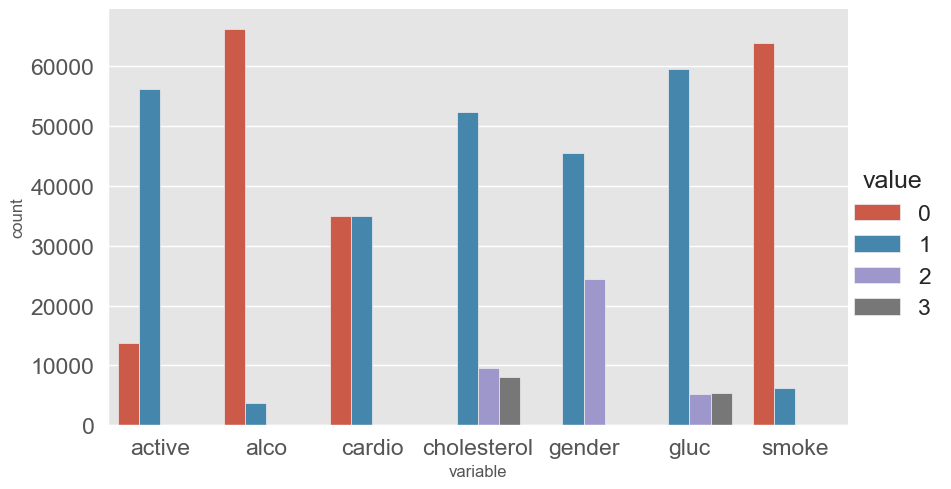

In [4]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active', 'cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 
                                              'value'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value',
            data=df_uniques, kind='bar', aspect=1.75)

Ми бачимо, що цільові класи збалансовані. Це чудово!

Далі розділимо набір даних за цільовими значеннями. Чи можете ви вже помітити найважливішу ознаку, просто глянувши на графік?

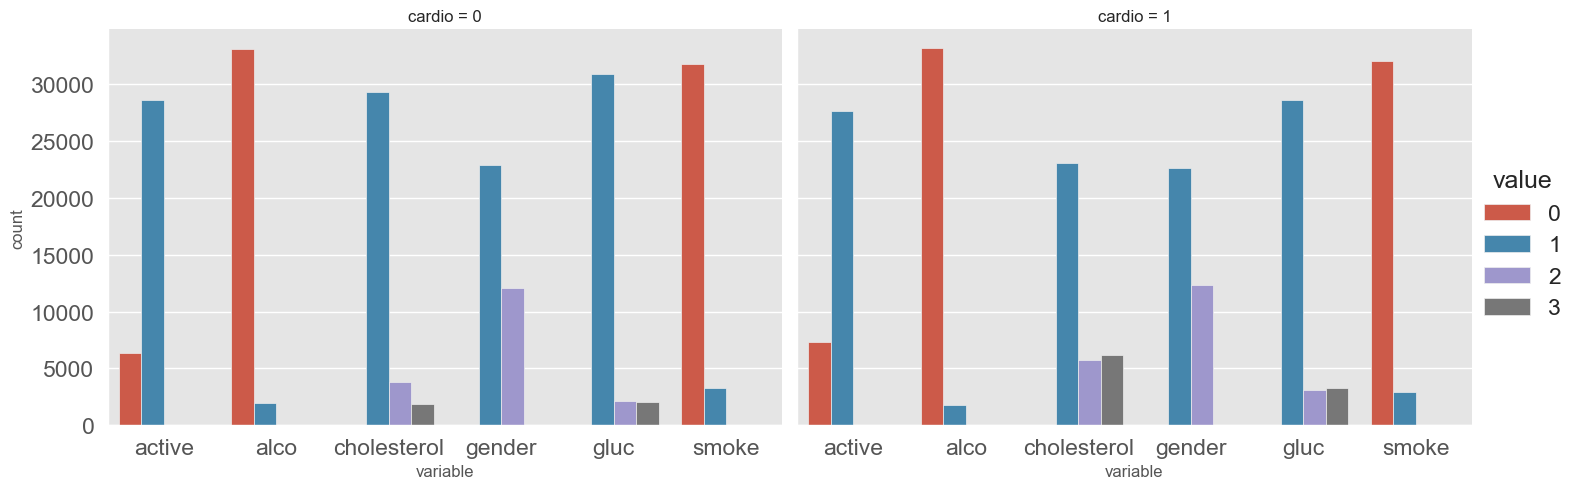

In [5]:
df_uniques = pd.melt(frame=df, value_vars=['gender','cholesterol', 
                                           'gluc', 'smoke', 'alco', 
                                           'active'], 
                     id_vars=['cardio'])
df_uniques = pd.DataFrame(df_uniques.groupby(['variable', 'value', 
                                              'cardio'])['value'].count()) \
    .sort_index(level=[0, 1]) \
    .rename(columns={'value': 'count'}) \
    .reset_index()

sns.catplot(x='variable', y='count', hue='value', 
               col='cardio', data=df_uniques, kind='bar', aspect=1.5)

Бачимо, що розподіл рівнів холестерину та глюкози сильно відрізняється за значенням цільової змінної. Це випадковість?

Тепер обчислимо деякі статистичні показники для унікальних значень ознак:

In [6]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * '-')

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


У підсумку, маємо:
- 5 числових ознак (за винятком *id*);
- 7 категоріальних ознак;
- Всього 70000 записів.

## 1.1. Основні спостереження

### <span style="color:red; font-size:1.5em;">Завдання 1</span>

**Варіант 1 – Профіль тиску за холестерином (cardio-стратифікація):**  
- Мета: описати, як змінюються `ap_hi` і `ap_lo` із зростанням `cholesterol`, окремо для `cardio`=0/1.  
- Кроки:
  - Обчисліть середні, медіани та 95% ДІ (бутстреп, B≥2000) для `ap_hi`, `ap_lo` у групах `cholesterol`×`cardio`.
  - Додайте N у кожній групі; маскуйте групи з N<30.
  - Порівняйте профілі `cardio`=0 vs `cardio`=1.  
- Підказки: `df.groupby(['cholesterol','cardio']).agg(...)`; бутстреп рядків групи.  
- Візуалізація: кластерний `barplot` із похибками; фасети за `cardio`.  
- Інтерпретація: чи є монотонний тренд тиску зі зростанням `cholesterol`; де відмінності найбільші.

**Варіант 2 – Віковий профіль за активністю і статтю:**  
- Мета: зіставити розподіли `age` для `active`=0/1 у чоловіків і жінок.  
- Кроки:
  - Переведіть `age_years = age/365.25`. Побудуйте гістограми (нормовані) або KDE для `active`=0/1 у фасетах `gender`.
  - Обчисліть медіани, IQR і Δмедіан між `active` групами у кожній статі (95% ДІ бутстрепом).  
- Підказки: вирівнюйте бінінг для коректного порівняння; додавайте легенду N.  
- Візуалізація: накладені гістограми/KDE + таблиця медіан/IQR/Δ.  
- Інтерпретація: у кого розподіл “старший” і чи це однаково для статей.

**Варіант 3 – Перехресні частки `gluc` × `gender` із розбиттям за `alco`:**  
- Мета: виявити статеві відмінності розподілу `gluc` залежно від вживання алкоголю.  
- Кроки:
  - Побудуйте перехресні таблиці часток `pd.crosstab(gender, gluc, normalize='index')` окремо для `alco`=0/1.
  - Обчисліть відхилення від загального розподілу (Δкомірка = частка підгрупи − частка загалом).  
- Підказки: підпишіть комірки N і Δ для інтерпретації.  
- Візуалізація: 2 heatmap (для `alco`=0/1) з анотаціями часток і Δ.  
- Інтерпретація: у яких комірках статеві відмінності найбільші й як на це впливає `alco`.

**Варіант 4 – Співвідношення статей у групах активності за категоріями АТ:**  
- Мета: оцінити баланс `gender` у `active`=0/1 залежно від категорій тиску.  
- Кроки:
  - Складіть категорії АТ (на основі `ap_hi`/`ap_lo`: норма/підвищений/гіпертензія 1/2/3).
  - Порахуйте частки `gender` у `active`=0 та `active`=1 для кожної категорії АТ.  
- Підказки: використовуйте 100% стек-бари або мозаїчні діаграми.  
- Візуалізація: `catplot(kind='bar', col=bp_cat, hue=gender, ...)` з нормуванням до 100%.  
- Інтерпретація: чи змінюється гендерний баланс активності залежно від категорії АТ.

**Варіант 5 – Антропометрія у вікових квінтилях:**  
- Мета: порівняти розподіли `height` і `weight` між віковими квінтилями.  
- Кроки:
  - Побудуйте `age_years` і розбийте на 5 квінтилів (`pd.qcut`).
  - Для кожного квінтиля побудуйте box/boxen для `height` і `weight`; обчисліть коефіцієнт варіації (CV) для кожної ознаки.  
- Підказки: додавайте однакові осі для порівнянності.  
- Візуалізація: фасетовані boxen-плоти та barplot CV по квінтилях.  
- Інтерпретація: як змінюється варіабельність з віком.

**Варіант 6 – `cholesterol` у групах `alco` із фасетами `active`:**  
- Мета: порівняти розподіли `cholesterol` у залежності від `alco` та `active`.  
- Кроки:
  - Побудуйте violin/stripplot для `cholesterol` у групах `alco`=0/1 з фасетами `active`.
  - Додайте частки `cholesterol`=3 з 95% ДІ (Вільсона) у підписах.  
- Підказки: забезпечте достатні N; маскуйте рідкісні клітинки.  
- Візуалізація: `catplot(kind='violin', col='active', hue='alco')` + анотації часток.  
- Інтерпретація: де частка високого холестерину найбільша.

**Варіант 7 – Розподіл `ap_hi` за `active` зі стратифікацією `gluc`:**  
- Мета: зіставити `ap_hi` у `active`=0/1 окремо для рівнів `gluc`.  
- Кроки:
  - Побудуйте violin для `ap_hi` у `active`=0/1 у фасетах `gluc`=1/2/3.
  - Обчисліть Δмедіан (активні − неактивні) з 95% ДІ у кожному рівні `gluc`.  
- Підказки: додавайте IQR; сортуйте фасети за зростанням Δ.  
- Візуалізація: violin-плоти + таблиця Δмедіан.  
- Інтерпретація: у яких рівнях `gluc` активність асоційована з нижчим тиском.

**Варіант 8 – Спільний розподіл `cholesterol`×`gluc` за статтю:**  
- Мета: порівняти пропорції комбінацій `cholesterol`×`gluc` у чоловіків і жінок.  
- Кроки:
  - Побудуйте 3×3 таблиці часток для кожної статі (нормалізація до 100%).
  - Порахуйте різниці часток між статями для кожної комірки.  
- Підказки: додавайте N; маркуйте значущі відмінності (бутстреп різниці).  
- Візуалізація: дві heatmap часток + heatmap різниць (дивергентна палітра).  
- Інтерпретація: які комбінації найсильніше відрізняються між статями.

**Варіант 9 – Тренди `ap_lo` за `cholesterol` у квінтилях `height`:**  
- Мета: оцінити, як змінюється `ap_lo` з `cholesterol` у підгрупах за зростом.  
- Кроки:
  - Розбийте `height` на квінтилі; для кожного квінтиля обчисліть середній `ap_lo` по `cholesterol` з 95% ДІ.
  - Побудуйте лінії тренду для кожного квінтиля.  
- Підказки: однакова шкала Y для порівнянності; сортуйте легенду за медіаною `height`.  
- Візуалізація: `lineplot` з CI, hue=квінтиль `height`.  
- Інтерпретація: чи змінюється схил тренду залежно від зросту.

**Варіант 10 – Вікові профілі в `cholesterol`×`smoke`:**  
- Мета: порівняти вік між `cholesterol`=1 та 3, окремо для `smoke`=0/1.  
- Кроки:
  - Побудуйте box/violin для `age_years` у 4 підгрупах (`chol`∈{1,3} × `smoke`∈{0,1}).
  - Обчисліть Δмедіан і частку віку >60 у кожній підгрупі (з 95% ДІ).  
- Підказки: балансуйте N між підгрупами; додавайте анотації Δ і часток.  
- Візуалізація: кластерний `boxplot` + таблиця Δ/часток.  
- Інтерпретація: де спостерігається найбільший “зсув” віку.

**Варіант 11 – Середній/медіанний вік за квінтилями `ap_lo` і статтю:**  
- Мета: дослідити зв’язок `age_years` з рівнями діастолічного тиску за статтю.  
- Кроки:
  - Розбийте `ap_lo` на квінтилі; для кожної статі обчисліть mean/median `age_years` і 95% ДІ.
  - Побудуйте лінії (X – квінтиль `ap_lo`) окремо для статей.  
- Підказки: перевірте монотонність (Спірмен ρ між квінтилем і віком).  
- Візуалізація: `lineplot` із CI, hue=`gender`.  
- Інтерпретація: чи старші пацієнти мають вищий `ap_lo` і чи відрізняється це за статтю.

**Варіант 12 – `cholesterol`×`gluc`: маса тіла, ІМТ і частка `cardio`:**  
- Мета: поєднати метаболічні маркери з антропометрією та ціллю.  
- Кроки:
  - У кожній комірці `cholesterol`×`gluc` обчисліть mean `weight`, mean `bmi`, частку `cardio`=1 (з 95% ДІ).
  - Порівняйте ранжування комірок за кожним показником.  
- Підказки: додайте N; виділіть топ‑3 комірки за кожним показником.  
- Візуалізація: фасетовані барплоти або heatmap трьох показників.  
- Інтерпретація: які комбінації поєднують вищу масу тіла та ризик.

**Варіант 13 – Частка `cholesterol`=3 у `smoke`×`active`:**  
- Мета: знайти комбінації поведінкових факторів з найбільшою часткою високого холестерину.  
- Кроки:
  - Для 4 комбінацій `smoke`∈{0,1} × `active`∈{0,1} порахуйте частку `cholesterol`=3 і 95% ДІ (Вільсона).
  - Додайте абсолютну різницю від бази (`smoke`=0, `active`=1).  
- Підказки: підписи з N і ДІ допоможуть інтерпретувати надійність.  
- Візуалізація: кластерний `barplot` із похибками.  
- Інтерпретація: які патерни поведінки пов’язані з вищим `cholesterol`.

**Варіант 14 – Середній вік vs `cholesterol` за статтю і `alco`:**  
- Мета: оцінити, чи збільшується `age_years` зі зростанням `cholesterol` однаково для статей та `alco`.  
- Кроки:
  - Побудуйте `lineplot` mean `age_years` (з 95% ДІ) по `cholesterol`, у фасетах `gender` та hue=`alco`.
  - Позначте можливі “злами” тренду (LOWESS для орієнтиру).  
- Підказки: однакова шкала Y між фасетами.  
- Візуалізація: лінії зі стрічками ДІ; тонка LOWESS поверх ліній.  
- Інтерпретація: як стать і алкоголь модифікують зв’язок вік–холестерин.

**Варіант 15 – Вікові розподіли у 8 комбінаціях `gender`×`smoke`×`alco` (фасети `active`):**  
- Мета: комплексно порівняти вікові розподіли між поведінково-демографічними групами.  
- Кроки:
  - Для 8 комбінацій побудуйте violin `age_years`, у фасетах `active`=0/1.
  - Додайте медіани, IQR і ранжуйте групи за медіаною віку.  
- Підказки: забезпечте читабельність підписів груп; додайте N.  
- Візуалізація: фасетовані violin з підписами медіан/IQR.  
- Інтерпретація: у яких групах віковий профіль зміщується найбільше.

**Варіант 16 – Стандартизовані `ap_hi` (z‑score) за `gluc`:**  
- Мета: перевірити, чи нижчий `gluc` пов’язаний із нижчим стандартизованим тиском.  
- Кроки:
  - Усередині 5‑річних вікових інтервалів стандартизуйте `ap_hi` (z‑оцінка).
  - Обчисліть mean z(`ap_hi`) і 95% ДІ у `gluc`=1/2/3; порівняйте.  
- Підказки: бутстреп на рівні рядків; маскуйте групи з N<30.  
- Візуалізація: `barplot` із похибками, X=`gluc`.  
- Інтерпретація: чи тренд зберігається після контролю віку.

**Варіант 17 – `gluc` за статтю у розрізі `cardio`:**  
- Мета: дослідити статеві відмінності розподілу `gluc` залежно від статусу `cardio`.  
- Кроки:
  - Побудуйте countplot `gluc` з нормалізацією всередині `gender`, окремо для `cardio`=0/1.
  - Додайте відносні частки й Δ між статями в кожній категорії `gluc`.  
- Підказки: збережіть однакові осі для порівняння.  
- Візуалізація: 2 countplot (cardio=0/1) з підписами часток.  
- Інтерпретація: де статус `cardio` супроводжується більшими статевими відмінностями `gluc`.

**Варіант 18 – Взаємодія `cholesterol` × `active` на частці `cardio`=1:**  
- Мета: оцінити, чи активність послаблює асоціацію `cholesterol` з `cardio`.  
- Кроки:
  - Для кожної комбінації `chol`×`active` порахуйте частку `cardio`=1 та 95% ДІ (Вільсона).
  - Побудуйте `pointplot`/`barplot` і порівняйте різниці між `active`=0 та 1 у межах рівнів `chol`.  
- Підказки: додайте N у підписах; перевірте монотонність за `chol`.  
- Візуалізація: `pointplot` з CI, hue=`active`.  
- Інтерпретація: чи “згладжує” активність негативний профіль холестерину.

**Варіант 19 – `ap_lo` у `active` групах із фасетами `gluc`:**  
- Мета: виявити, чи різниця `ap_lo` між `active`=0/1 залежить від `gluc`.  
- Кроки:
  - Побудуйте boxplot `ap_lo` за `active`=0/1 у фасетах `gluc`=1/2/3; додайте медіани/IQR у підписах.
  - Обчисліть Δмедіан (активні − неактивні) з 95% ДІ у кожній фасеті.  
- Підказки: сортуйте фасети за Δмедіан; додавайте N.  
- Візуалізація: фасетовані boxplot + таблиця Δ.  
- Інтерпретація: де вплив активності на `ap_lo` найбільш виражений.

**Варіант 20 – Вікова стандартизація частки високого АТ за `alco` і `cholesterol`:**  
- Мета: порівняти частку “високого АТ” між `alco`=0/1 у кожному рівні `cholesterol`, контролюючи вік.  
- Кроки:
  - Визначте поріг “високого АТ” (на основі `ap_hi`/`ap_lo`). Побудуйте вікові 5‑річні інтервали.
  - Розрахуйте віково-стандартизовані частки для `alco`=0 і `alco`=1 всередині кожного `cholesterol`; 95% ДІ – бутстреп.
  - Порівняйте абсолютні та відносні різниці між `alco` групами.  
- Підказки: використовуйте спільний віковий розподіл як стандарт.  
- Візуалізація: стовпчикові діаграми стандартизованих часток із похибками.  
- Інтерпретація: у яких рівнях `cholesterol` ефект `alco` найбільший після контролю віку.

## 1.2. Мапи ризиків

На вебсайті Європейського товариства кардіологів надається [шкала SCORE](https://www.escardio.org/Education/Practice-Tools/CVD-prevention-toolbox/SCORE-Risk-Charts). Вона використовується для розрахунку ризику смерті від серцево-судинного захворювання в найближчі 10 років. Ось вона:

<img src=https://raw.githubusercontent.com/radiukpavlo/intelligent-data-analysis/main/03_img/2_3_risk-map.png width=50%>

Глянемо на верхній правий прямокутник, який показує підгрупу курців у віці від 60 до 65 років. (Це неочевидно, але значення на мапі відображають верхню межу).

Ми бачимо значення 9 у нижньому лівому куті прямокутника та 47 у верхньому правому. Це означає, що для людей-курців цієї статево-вікової групи, у яких систолічний тиск менше 120 (сегмент 1), ризик серцево-судинних захворювань оцінюється в 5 разів нижче, ніж для тих курців, хто має тиск в інтервалі [160, 180) (сегмент 2).

Далі обчисліть цей коефіцієнт, використовуючи статистичні дані.

> ***Примітка:***
> - Розрахувати ознаку ``age_years`` – округлити вік до найближчої кількості років. Для цього завдання відбирайте лише людей віком [60;64].
> - Категорії рівня холестерину відрізняються між цифрою та нашим набором даних. Перерахунок для ознаки ``cholesterol`` наступний: 4 mmol/l $\rightarrow$ 1, 5-7 mmol/l $\rightarrow$ 2, 8 mmol/l $\rightarrow$ 3.
> - Уникайте спотворень через малі вибірки: замасковуйте або об’єднуйте рідкісні клітинки.  
> - Використовуйте єдині краї бінів для мап, які порівнюються між собою.  
> - Для бутстрепу ресемпліть рядки клітинки з поверненням; з B≥2000 результат стає стабільнішим.  
> - Додавайте в легенду пояснення шкал (absolute risk, RR, RD, Δ тощо) і зазначайте одиниці/пороги. 

### <span style="color:red; font-size:1.5em;">Завдання 2</span>

**Варіант 1 – Мапа ризику age × ap_hi:**  
- Мета: побудувати теплову мапу абсолютного ризику ССЗ (`cardio`) у сітці `age_years` × `ap_hi`.  
- Кроки: 
  - Обчисліть `age_years = age/365.25`. Задайте бінінг: вік – крок 5 років; `ap_hi` – квінтилі або фіксовані інтервали (напр., 110–130–140–160–180+).
  - Для кожної клітинки порахуйте середній ризик (mean `cardio`) і 95% ДІ бутстрепом (B≥2000). Додайте N. Маскуйте клітинки з N < 30.  
- Підказки: `pd.cut`, `pd.qcut`, `groupby`, бутстреп через ресемпл рядків клітинки.  
- Візуалізація: `seaborn.heatmap` з анотаціями (N, або mean±CI у тултипі/легенді).  
- Інтерпретація: знайдіть “хребти” підвищеного ризику вздовж осей віку і тиску.

**Варіант 2 – Гендерні мапи age × ap_lo + мапа різниць:**  
- Мета: порівняти ризик ССЗ між `gender` у площині `age_years` × `ap_lo`, а також побудувати мапу різниць (чол − жін).  
- Кроки:
  - Створіть дві мапи абсолютного ризику (окремо для `gender`=0/1) у однаковій сітці бінів.
  - Розрахуйте мапу різниць ризику між гендерами; додайте 95% ДІ різниць бутстрепом.  
- Підказки: зберігайте однакові краї бінів для порівнянності; використайте дивергентну палітру для різниць.  
- Візуалізація: 2 фасети heatmap + heatmap різниць (маскуйте N<30).  
- Інтерпретація: вкажіть зони максимальних гендерних відмінностей.

**Варіант 3 – Кардіомапа ap_hi × ap_lo з клінічними порогами:**  
- Мета: теплову мапу абсолютного ризику у координатах `ap_hi` × `ap_lo` з контурними лініями ризику.  
- Кроки:
  - Задайте бінінг `ap_hi` і `ap_lo` (клінічно осмислені діапазони). Обчисліть mean `cardio`, 95% ДІ і N.  
  - Додайте контури однакових рівнів ризику; накладіть лінії клінічних порогів (напр., 140/90).  
- Підказки: `plt.contour/contourf`, кольорова мапа від низького до високого ризику.  
- Інтерпретація: визначте “острови” дуже високого ризику та їх положення відносно порогів.

**Варіант 4 – Мапа age × BMI (hexbin/2D-біни):**  
- Мета: оцінити спільний вплив віку та ІМТ на ризик.  
- Кроки:
  - Обчисліть `bmi = weight / (height/100)**2`. Побудуйте бінінг віку (5 років) і BMI (напр., 18.5–25–30–35–40+ або квантилі).  
  - Обчисліть mean `cardio`, 95% ДІ; додайте N. За бажанням – альтернативна візуалізація `plt.hexbin` з медіаною/середнім ризику в гексах.  
- Підказки: накладіть криві рівного ІМТ (ізолінії) або підпишіть межі категорій ВООЗ.  
- Інтерпретація: де градієнт ризику найбільший – по віку чи по ІМТ?

**Варіант 5 – Дискретна мапа cholesterol × gluc (9 клітинок):**  
- Мета: порівняти ризик у всіх комбінаціях `cholesterol`∈{1,2,3} і `gluc`∈{1,2,3}.  
- Кроки:
  - Для кожної комбінації обчисліть: абсолютний ризик, RR до бази (1,1), RD до бази; 95% ДІ (для RR – через лог-трансформацію або бутстреп).  
  - Візуалізуйте heatmap RR; позначте клітинки зі значущим підвищенням (ДІ RR не містить 1).  
- Підказки: збережіть таблицю з N для прозорості.  
- Інтерпретація: які комбінації є “подвійно шкідливими”?

**Варіант 6 – Стандартизація за статтю для мапи age × cholesterol:**  
- Мета: порівняти “сира” і стандартизована за `gender` мапи ризику у сітці `age_years` × `cholesterol`.  
- Кроки:
  - “Сира” мапа: mean `cardio` у клітинках.  
  - Стандартизована: зважте гендер-специфічні ризики клітинки на спільний (популяційний) розподіл статі.  
- Підказки: пряме зведення – ∑(w_gender × risk_gender_cell), де w – загальні частки статей.  
- Інтерпретація: як контроль за статтю змінює патерни ризику?

**Варіант 7 – Мапа height × weight з кривими рівного ІМТ та мапою невизначеності:**  
- Мета: дослідити ризик у просторі антропометрії та оцінити невизначеність.  
- Кроки:
  - Побудуйте heatmap ризику (`height` × `weight`) і окремо heatmap ширини 95% ДІ (або SE) для кожної клітинки.  
  - Накладіть криві ІМТ (25, 30, 35). Маскуйте клітинки з N<30.  
- Підказки: використовуйте однакову сітку для обох мап.  
- Інтерпретація: де високий ризик супроводжується високою невизначеністю?

**Варіант 8 – Дельта-мапа ефекту куріння (smoke):**  
- Мета: оцінити додатковий ризик, пов’язаний із `smoke`, у сітці `age_years` × `cholesterol`.  
- Кроки:
  - Для кожної клітинки порахуйте `Δrisk = risk(smoke=1) − risk(smoke=0)` і 95% ДІ бутстрепом.  
  - Відобразіть Δrisk як дивергентну heatmap; замаскуйте клітинки з малим N або where groups missing.  
- Підказки: покажіть також таблицю часток курців у клітинках (контекст).  
- Інтерпретація: у яких віково-холестеринових зонах куріння найбільш шкідливе?

**Варіант 9 – Мапи ap_hi × gluc у фасетах cholesterol:**  
- Мета: виявити взаємодію `ap_hi` з `gluc`, модифіковану `cholesterol`.  
- Кроки:
  - Побудуйте 3 фасети heatmap ризику (`cholesterol`=1/2/3) у однаковій сітці `ap_hi` × `gluc`.  
  - Додайте контури/ізолінії; порівняйте форму “високоризикових” зон між фасетами.  
- Підказки: однакова нормалізація кольорів для порівнянності.  
- Інтерпретація: чи посилює високий холестерин ризик при підвищеній глюкозі й тиску?

**Варіант 10 – RR активності (active) у сітці age × BMI:**  
- Мета: Мапа відносного ризику `RR = risk(active=1)/risk(active=0)` у сітці `age_years` × `bmi`.  
- Кроки:
  - Обчисліть ризики для `active`=0/1 у кожній клітинці; порахуйте RR та 95% ДІ (лог-метод або бутстреп).  
  - Замаскуйте клітинки з N малою в будь-якій групі.  
- Підказки: дивергентна палітра для log(RR) або послідовна для RR>0; підписи клітинок з N.  
- Інтерпретація: де активність має найбільший “захисний” ефект (RR<1)?

**Варіант 11 – Мапа ймовірності “ризик вище порогу”:**  
- Мета: для сітки `age_years` × `ap_hi` оцінити P(ризик > baseline + 5 п.п.).  
- Кроки:
  - Для baseline візьміть загальнопопуляційний mean `cardio`.  
  - Бутстрепом оцініть у кожній клітинці ймовірність перевищення порогу.  
- Підказки: B≥3000 для плавної оцінки; маска N<30.  
- Інтерпретація: “впевнені” гарячі точки – P≥0.9.

**Варіант 12 – Мапа невизначеності (ширина 95% ДІ) для age × ap_lo:**  
- Мета: показати, де оцінки ризику нестабільні/неточні.  
- Кроки:
  - Для сітки `age_years` × `ap_lo` розрахуйте ширину 95% ДІ (upper−lower) для ризику.  
  - Побудуйте heatmap цієї ширини; додайте контури для порогів невизначеності (напр., 0.10).  
- Підказки: розгляньте кореляцію з N у клітинці.  
- Інтерпретація: як невизначеність накладається на “гарячі” зони ризику?

**Варіант 13 – Модельна мапа (логістична регресія) age × ap_hi:**  
- Мета: порівняти спостережний і модельний ризик.  
- Кроки:
  - Навчіть логістичну модель `cardio ~ age_years + ap_hi + ap_lo + cholesterol + gluc + gender + smoke + alco + active + bmi`.  
  - На регулярній сітці `age_years` × `ap_hi` (інші змінні фіксуйте) обчисліть прогноз ризику; побудуйте heatmap.  
  - Зіставте зі спостережною мапою (з варіанта 1).  
- Підказки: `sklearn.linear_model.LogisticRegression` або `statsmodels`.  
- Інтерпретація: де модель узгоджується/розбігається зі спостереженнями?

**Варіант 14 – Калібраційна мапа (observed − predicted):**  
- Мета: знайти систематичні зони недооцінки/переоцінки моделі.  
- Кроки:
  - Для кожної клітинки розрахуйте `Δ = risk_observed − risk_predicted` (з моделі варіанта 13).  
  - Побудуйте дивергентну heatmap Δ; додайте 95% ДІ для Δ бутстрепом.  
- Підказки: однакова сітка бінів, що в моделі-порівнянні.  
- Інтерпретація: у яких віково-тонічних областях модель помиляється найбільше?

**Варіант 15 – “Hotspot” мапування у ap_hi × ap_lo:**  
- Мета: знайти локальні піки ризику, згладивши поле.  
- Кроки:
  - Побудуйте heatmap ризику і застосуйте 2D-згладжування (напр., `scipy.ndimage.gaussian_filter` або 2D-ковзне середнє).  
  - Ідентифікуйте топ‑5 локальних максимумів; для кожного дайте координати (центри бінів), ризик і 95% ДІ.  
- Підказки: тримайте σ згладжування помірним; не “розмазуйте” структуру.  
- Інтерпретація: чи збігаються піки зі зрозумілими клінічними зонами?

**Варіант 16 – Мапа приросту ризику від холестерину:**  
- Мета: оцінити вплив `cholesterol` у сітці `age_years` × `ap_hi`.  
- Кроки:
  - Для кожної клітинки обчисліть `Δchol = risk(chol=3) − risk(chol=1)`, контролюючи `gender` (стратифікація або стандартизація).  
  - Побудуйте heatmap Δchol з 95% ДІ (бутстреп). Маскуйте клітинки з браком даних у підгрупах.  
- Підказки: однакова сітка для груп `chol`.  
- Інтерпретація: де різниця між `chol=3` і `chol=1` найбільша?

**Варіант 17 – Мапа синергії cholesterol × gluc:**  
- Мета: перевірити, чи спільний ефект більший/менший за адитивний.  
- Кроки:
  - Для кожної дискретної комірки (chol × gluc) обчисліть: `synergy = risk(chol,gluc) − [risk(chol) + risk(gluc) − risk(baseline)]`.  
  - Візуалізуйте heatmap синергії з 95% ДІ бутстрепом; позначте значущі клітинки.  
- Підказки: baseline – `chol=1, gluc=1`.  
- Інтерпретація: де є позитивна синергія (підсилення ефектів), де – антагонізм?

**Варіант 18 – Мапа стабільності (CV) у age × BMI (бутстреп):**  
- Мета: проаналізувати стабільність оцінок ризику.  
- Кроки:
  - Проведіть B бутстреп-циклів; кожного разу оцініть ризик у клітинках сітки `age_years` × `bmi`.  
  - Для кожної клітинки обчисліть коефіцієнт варіації (CV) ризику та побудуйте heatmap CV.  
- Підказки: виділіть клітинки з CV вище порога (напр., 0.3).  
- Інтерпретація: де висновки менш надійні через мінливість?

**Варіант 19 – Багатомасштабна узгодженість у age × ap_hi:**  
- Мета: оцінити чутливість “гарячих зон” до масштабу бінінгу.  
- Кроки:
  - Побудуйте мапи ризику для кількох масштабів (кроки віку: 3/5/7 років; `ap_hi`: квінтилі/децилі/фіксовані).  
  - Для кожної позиції ґратки визначте частку конфігурацій, де клітинка класифікована як високоризикова (топ‑квінтиль).  
- Підказки: нормуйте мапи до спільної референтної сітки.  
- Інтерпретація: де висновки стабільні попри зміну масштабу?

**Варіант 20 – Композитний ризиковий бал × вік:**  
- Мета: побудувати мапи абсолютного та відносного ризику за композитним балом.  
- Кроки:
  - Складіть бал (1 пункт за кожний критерій: `ap_hi`≥140, `ap_lo`≥90, `chol`=3, `gluc`=3, `smoke`=1, `alco`=1, `active`=0).  
  - У сітці `age_years` × `score` розрахуйте абсолютний ризик і RR відносно `score=0` у кожній віковій групі; додайте 95% ДІ.  
  - Побудуйте дві heatmap: абсолютного ризику та RR.  
- Підказки: маскуйте комірки з N<20 для високих балів.  
- Інтерпретація: назвіть “зони особливого занепокоєння” на обох мапах. 

## 1.3. Аналіз ІМТ

> ***Примітка:*** 
> - Перед аналізом розрахуйте `bmi = weight / (height/100)**2` та, за потреби, `age_years = age / 365.25`. 
> - Перевіряйте якість даних, розгляньте виявлення і вплив потенційних артефактів (див. варіант 11) і маскуйте рідкісні бін-клітинки (наприклад, N<30).
> - Для довірчих інтервалів використовуйте бутстреп (B≥2000).
> - Завжди супроводжуйте візуалізації числовими підсумками (медіани, Δ, ДІ, N).
> - Перевіряйте чутливість висновків до вибору бінінгу/фільтрів (повторіть з альтернативними параметрами).
> - Підкреслюйте практичну значущість (розмір ефекту), а не лише статистичну.
> - Рекомендовані інструменти: pandas (`groupby`, `cut`/`qcut`), seaborn (`boxplot`, `violinplot`, `kdeplot`, `heatmap`, `catplot`, `pointplot`), matplotlib.

### <span style="color:red; font-size:1.5em;">Завдання 3</span>

**Варіант 1 – ІМТ vs холестерин із контролем віку/статі:**  
- Мета: перевірити, чи вищі рівні `cholesterol` асоційовані з більшим ІМТ після контролю за віком і статтю.  
- Кроки:
  - Обчисліть `bmi = weight / (height/100)**2` і `age_years = age/365.25`.
  - Розбийте `age_years` на 5‑річні інтервали; сформуйте групи за `cholesterol`, віком і `gender`.
  - У кожній комірці обчисліть середній/медіанний ІМТ і 95% ДІ (бутстреп, B≥2000).
  - Стандартизуйте за віком і статтю (зважуванням на спільний розподіл) і візуалізуйте кластерним barplot.  
- Підказки: використовуйте `pd.cut`/`groupby`; для ДІ – ресемпл рядків у комірці.  
- Інтерпретація: оцініть монотонність тренду ІМТ за рівнями `cholesterol` і різниці між статями.

**Варіант 2 – Нелінійний зв’язок ІМТ із віком за статтю:**  
- Мета: виявити форму залежності ІМТ від віку та статеві відмінності.  
- Кроки:
  - Побудуйте бінінг за віком (крок 1–2 роки) для стабілізації оцінок.
  - Для `gender`=0/1 побудуйте `lineplot` ІМТ vs `age_years` зі згладжуванням (LOWESS/ковзні середні) і 95% ДІ.
  - Обчисліть наближену похідну (різниці між сусідніми бін-пунктами) й відобразьте окремою панеллю.  
- Підказки: дбайте про однакові краї бінів між статями; маскуйте бін-клітинки з N<30.  
- Інтерпретація: де та як швидко змінюється ІМТ з віком у чоловіків/жінок.

**Варіант 3 – ІМТ і куріння: стратифікація та стандартизація:**  
- Мета: оцінити різницю ІМТ між `smoke`=0/1 з контролем за віком і статтю.  
- Кроки:
  - У комірках (вікова група × `gender`) обчисліть середній ІМТ для `smoke`=0 і `smoke`=1.
  - Зведіть (стандартизуйте) до загального за спільним розподілом віку/статі.
  - Обчисліть різницю середніх (курці − некурці) з 95% ДІ (бутстреп комірок) і візуалізуйте pointplot.  
- Підказки: перевіряйте дисбаланси віку між групами; додавайте N у підписах.  
- Інтерпретація: чи існує стабільна різниця ІМТ, незалежна від віку/статі.

**Варіант 4 – ІМТ, алкоголь та активність: модифікація ефекту:**  
- Мета: перевірити, чи вплив `alco` на ІМТ змінюється залежно від `active`.  
- Кроки:
  - Створіть 2×2 підгрупи (`alco`×`active`) у вікових інтервалах.
  - Для кожної підгрупи обчисліть середній/медіанний ІМТ, ΔІМТ (alco1 − alco0) з 95% ДІ.
  - Порівняйте ΔІМТ між `active`=0 та `active`=1; візуалізуйте кластерним barplot із ДІ.  
- Підказки: фасетуйте за віковими групами; обов’язково показуйте N.  
- Інтерпретація: де активність пом’якшує/підсилює зв’язок алкоголю з ІМТ.

**Варіант 5 – ІМТ vs артеріальний тиск із частковою корекцією віку:**  
- Мета: дослідити градієнт ІМТ уздовж `ap_hi`/`ap_lo`, мінімізувавши вплив віку.  
- Кроки:
  - Розбийте `ap_hi` (і окремо `ap_lo`) на квінтилі; стандартизуйте ІМТ усередині вікових груп (z‑оцінки).
  - Побудуйте залежність стандартизованого ІМТ від квінтиля тиску з 95% ДІ (pointplot).
  - Повторіть для `ap_lo` і порівняйте профілі.  
- Підказки: зберігайте однакові краї квінтилів для порівнянності.  
- Інтерпретація: чи пов’язаний вищий тиск із більшим відносним ІМТ після контролю віку.

**Варіант 6 – Статевий диморфізм через “shift function”:**  
- Мета: кількісно оцінити зсув розподілів ІМТ між статями.  
- Кроки:
  - Обчисліть квантилі ІМТ (p10…p90) окремо для `gender`=0/1.
  - Побудуйте “shift function”: різниці відповідних квантилів (чол − жін) з 95% ДІ бутстрепом.
  - Додатково покажіть violin/box для контексту.  
- Підказки: використовуйте достатню ширину бінів для стабільності хвостів.  
- Інтерпретація: на яких квантилях відмінності найбільші (низ/центр/хвости).

**Варіант 7 – ІМТ і глюкоза: категорії ВООЗ і стандартизація:**  
- Мета: оцінити частки категорій ІМТ (ВООЗ) у рівнях `gluc` з урахуванням віку/статі.  
- Кроки:
  - Класифікуйте ІМТ: <18.5, 18.5–24.9, 25–29.9, 30–34.9, 35–39.9, ≥40.
  - Для кожного `gluc` порахуйте віково- і статево-стандартизовані частки категорій ІМТ.
  - Візуалізуйте 100% стек-барами; виділіть “ожиріння” окремим відтінком.  
- Підказки: додайте таблицю N по клітинках для прозорості.  
- Інтерпретація: чи зростає частка ожиріння зі збільшенням `gluc`.

**Варіант 8 – ІМТ і активність: вікова гетерогенність ефекту:**  
- Мета: дослідити, як різниця ІМТ між `active`=0/1 змінюється з віком.  
- Кроки:
  - У кожній віковій групі побудуйте violinplot ІМТ для `active`=0 і `active`=1.
  - Обчисліть Δмедіан (активні − неактивні) з 95% ДІ (бутстреп) і відобразьте pointplot над violin.  
- Підказки: маскуйте групи з N<30; відслідковуйте узгодженість знаку Δ у віці.  
- Інтерпретація: у яких віково-активнісних комбінаціях різниця найбільша.

**Варіант 9 – ІМТ і ризик ССЗ: децильний градієнт:**  
- Мета: перевірити зростання частки `cardio` за децилями ІМТ.  
- Кроки:
  - Розбийте ІМТ на 10 децилів; у кожному обчисліть mean `cardio` і 95% ДІ (бутстреп).
  - За потреби, побудуйте окремі криві для статей (hue).  
- Підказки: зберігайте достатню ширину децилів (мінімальний N на дециль).  
- Інтерпретація: оцініть монотонність (Спірмен ρ між децилем і ризиком).

**Варіант 10 – ІМТ як спостережний предиктор високої глюкози:**  
- Мета: оцінити залежність частки `gluc`=3 від бінів ІМТ із контролем віку/статі.  
- Кроки:
  - Побудуйте квінтилі ІМТ; в кожному – частка `gluc`=3 зі стандартизацією за віком і статтю.
  - Порахуйте Δчастки між крайніми квінтилями з 95% ДІ (бутстреп).
  - Відобразьте pointplot часток vs бін ІМТ, фасети – `gender`.  
- Підказки: перевірте чутливість до іншого бінінгу (терцілі/децилі).  
- Інтерпретація: чи спостерігається чіткий градієнт “ІМТ → висока глюкоза”.

**Варіант 11 – Артефакти вимірювань зросту/ваги й вплив на ІМТ:**  
- Мета: виявити аномальні значення антропометрії та їх вплив на висновки.  
- Кроки:
  - Побудуйте scatter `height` vs `weight` з ізо-лініями ІМТ (25/30/35/40) і підсвіткою підозрілих точок (наприклад, `height`<130 або >210; `weight`<35 або >200).
  - Повторіть ключові метрики (середній ІМТ, дисперсія, децилі) з/без аномалій; порівняйте.  
- Підказки: не видаляйте автоматично – лише демонструйте чутливість.  
- Інтерпретація: наскільки артефакти змінюють узагальнені висновки щодо ІМТ.

**Варіант 12 – Перцентильні криві ІМТ за віком і статтю:**  
- Мета: побудувати вікові перцентильні профілі ІМТ для статей.  
- Кроки:
  - Для кожного року або 2‑річного вікна обчисліть p5/p10/p25/p50/p75/p90/p95 ІМТ за статтю.
  - Згладьте перцентильні криві (ковзне вікно) і побудуйте багатолінійний графік.  
- Підказки: тримайте однакові шкали осей для порівнянності.  
- Інтерпретація: як зміщуються центри і хвости розподілу ІМТ з віком.

**Варіант 13 – ІМТ vs `cardio`: вікова стратифікація і SMD:**  
- Мета: порівняти ІМТ між `cardio`=0/1 у вікових групах і виміряти розмір ефекту.  
- Кроки:
  - У кожній віковій групі побудуйте violinplot ІМТ для `cardio`=0 та `cardio`=1.
  - Обчисліть standardized mean difference (SMD) ІМТ між групами; сформуйте таблицю SMD.  
- Підказки: SMD≈0.2/0.5/0.8 – малий/середній/великий ефекти.  
- Інтерпретація: де відмінності ІМТ між групами cardio найбільш виражені.

**Варіант 14 – ІМТ у клінічних категоріях артеріального тиску:**  
- Мета: оцінити розподіл ІМТ у класах АТ за `ap_hi` і `ap_lo`.  
- Кроки:
  - Сформуйте класи: норма/високий/гіпертензія 1/2/3 (клінічно вмотивовані пороги).
  - Побудуйте boxplot ІМТ по класах із фасетами за `gender`; додайте тест тренду ІМТ по класах.  
- Підказки: стандартизуйте ІМТ всередині віку для чутливісної перевірки.  
- Інтерпретація: чи зростає ІМТ разом із тяжчими категоріями тиску.

**Варіант 15 – Гетерогенність ІМТ за `cholesterol` × `gluc`:**  
- Мета: дослідити ІМТ у перехресних категоріях метаболічних маркерів.  
- Кроки:
  - Для 3×3 комбінацій (`cholesterol`×`gluc`) обчисліть середній/медіанний ІМТ і 95% ДІ; проведіть вікове зважування.
  - Візуалізуйте теплокартою середнього ІМТ з анотацією N або кластерним barplot.  
- Підказки: маскуйте рідкісні клітинки; тримайте спільну шкалу кольору.  
- Інтерпретація: у яких комбінаціях маркерів ІМТ найбільший.

**Варіант 16 – ІМТ та активність: ламані (наближення сплайнів):**  
- Мета: показати нелінійність різниці ІМТ між `active`=0/1 уздовж віку.  
- Кроки:
  - Оберіть вузли віку (квантілі) і сформуйте інтервали.
  - Для `active`=0/1 у кожному інтервалі обчисліть середній ІМТ і 95% ДІ; з’єднайте ламаними.
  - Позначте позиції вузлів і ділянки найбільшого розходження.  
- Підказки: альтернативно використайте LOWESS для обох груп і візуалізуйте різницю кривих.  
- Інтерпретація: у яких вікових відрізках активність асоціюється з більш низьким ІМТ.

**Варіант 17 – ІМТ vs `ap_lo`: теплокарта і карта градієнтів:**  
- Мета: оцінити локальні зв’язки ІМТ з `ap_lo` у сітці за віком.  
- Кроки:
  - Побудуйте теплокарту середнього ІМТ у сітці `age_years` × `ap_lo` (квантілі або фіксовані бін-інтервали).
  - Обчисліть локальні градієнти (різниця між сусідніми клітинками) та візуалізуйте окремою дивергентною картою.  
- Підказки: однакова сітка/маска для обох карт; у легенді поясніть одиниці.  
- Інтерпретація: де ІМТ різко змінюється уздовж діастолічного тиску.

**Варіант 18 – ІМТ, тиск і глюкоза: фасетовані порівняння:**  
- Мета: порівняти ІМТ між рівнями `gluc` за різних режимів тиску.  
- Кроки:
  - Створіть категорії `ap_hi` (напр., <130, 130–139, ≥140).
  - Усередині кожної категорії побудуйте boxplot ІМТ для `gluc`=1/2/3; додайте Δмедіан (gluc3 − gluc1) з 95% ДІ у підписах.  
- Підказки: фасетуйте за рівнями `ap_hi`; контролюйте N; однакові осі.  
- Інтерпретація: як зростання глюкози пов’язано зі зсувом ІМТ на різних рівнях тиску.

**Варіант 19 – Мінімум частки високої глюкози вздовж ІМТ:**  
- Мета: знайти бін ІМТ з мінімальною часткою `gluc`=3 і оцінити стабільність.  
- Кроки:
  - Побудуйте бінінг ІМТ із кроком 2 кг/м²; у кожному обчисліть частку `gluc`=3 з 95% ДІ.
  - Знайдіть бін із мінімумом; порівняйте з сусідніми бін-клітинками (Δчастки з ДІ).  
- Підказки: перевірте стабільність мінімуму в підгрупах за статтю/віком.  
- Інтерпретація: у якому діапазоні ІМТ висока глюкоза трапляється найрідше.

**Варіант 20 – ІМТ vs `cholesterol` з віковими фасетами:**  
- Мета: показати, як розподіл ІМТ змінюється за рівнями `cholesterol` у різних вікових когортах.  
- Кроки:
  - Сформуйте вікові когорти (напр., 30–44, 45–59, 60–74, 75+).
  - Для кожної когорти побудуйте KDE розподілу ІМТ за `cholesterol`=1/2/3 або 100% стек-бари категорій ІМТ (ВООЗ).
  - Обчисліть і підпишіть Δсереднього ІМТ між `cholesterol`=3 та `cholesterol`=1.  
- Підказки: використовуйте однакові осі/шкали; додавайте N у легенди.  
- Інтерпретація: чи набуває різниця ІМТ за `cholesterol` виразнішого характеру у старших віках.

## 1.4. Очищення даних

Варто пам'ятати, дані не є ідеальними. Набір містить зайву інформацію та неточності. Візуалізуємо дані, щоби побачити це наочно.

### <span style="color:red; font-size:1.5em;">Завдання 4</span>

**Варіант 1 – Базова валідація діапазонів і звіт за правилами:**  
- Мета: застосувати набір базових правил якості та прозоро відзвітувати, скільки записів відкинув кожен фільтр.  
- Кроки:
  - Перевірте діапазони: `height`∈[140,210], `weight`∈[40,150], `ap_hi`∈[90,240], `ap_lo`∈[60,140], `cholesterol`∈{1,2,3}, `gluc`∈{1,2,3}, `smoke`,`alco`,`active`∈{0,1}, `gender`∈{1,2}.
  - Додайте логічні прапорці порушень по кожному правилу, збережіть їх у окремих стовпцях (наприклад, `rule_height_range`).
  - Підрахуйте відсоток відкинутих загалом і внесок кожного правила (частка записів, що порушили правило).
  - Створіть очищений датасет із записів, що не порушили жодного правила.  
- Підказки: використовуйте векторизовані перевірки та `df.filter(like='rule_')` для зручного підсумку.  
- Візуалізація: стовпчикова діаграма внеску кожного правила у видалення; кругова діаграма “залишилось vs відкинуто”.  
- Інтерпретація: визначте найкритичніші правила та обґрунтуйте їх залишення/послаблення.

**Варіант 2 – Вік у роках, валідація та ефект на розподіли:**  
- Мета: узгодити вік у роках, відкинути недопустимі значення та оцінити вплив на розподіли.  
- Кроки:
  - Обчисліть `age_years = age/365.25` та округліть до 1 знака (або не округляйте для точності).
  - Встановіть діапазон валідного віку, напр., [18, 90]. Відфільтруйте записи поза діапазоном.
  - Порівняйте гістограми `age_years` до/після чищення; підрахуйте % відкинутих.  
- Підказки: перевірте мін/макс до встановлення порогів; уникайте занадто вузьких інтервалів.  
- Візуалізація: дві накладені гістограми (до/після), кругова діаграма частки видалених.  
- Інтерпретація: оцініть, чи чищення не створює викривлення вікової структури.

**Варіант 3 – Логічна узгодженість артеріального тиску + пульсовий тиск:**  
- Мета: виправити переставлені місцями значення `ap_hi`/`ap_lo` і видалити нелогічні комбінації.  
- Кроки:
  - Виправте рядки, де `ap_lo > ap_hi`, шляхом перестановки (зафіксуйте кількість таких випадків).
  - Обчисліть пульсовий тиск `pp = ap_hi - ap_lo`. Залиште записи з `pp` у [20, 120].
  - Видаліть записи з `ap_hi` або `ap_lo` поза клінічно можливих меж (див. Варіант 1).  
- Підказки: перед видаленням оцініть, чи можна застосувати м’яке тримінгування (winsorization).  
- Візуалізація: гістограма `pp` до/після; стовпчикова діаграма кількості перестановок і видалень.  
- Інтерпретація: чи покращився вигляд розподілу тиску після корекцій.

**Варіант 4 – Аномалії масштабу в тиску (підозра на одиниці/клавіатурні помилки):**  
- Мета: виявити і коригувати/видаляти записи з підозрою на помилку масштабу (напр., зайвий нуль).  
- Кроки:
  - Позначте записи з `ap_hi > 300` або `ap_lo > 200` чи `ap_hi < 50` як підозрілі.
  - Спробуйте “безпечну” поправку: якщо `ap_hi` у [1000, 2500], діліть на 10; якщо `ap_lo` у [600, 1400], діліть на 10; повторно валідуючи діапазони.
  - Якщо після корекції значення поза межами – видалити такі записи.  
- Підказки: завжди логувати кількість “виправлених” і “видалених” для відтворюваності.  
- Візуалізація: порівняльні boxplot `ap_hi`/`ap_lo` до/після; таблиця дій: виправлено/видалено/залишено.  
- Інтерпретація: чи корекції підтримуються даними (розумні медіани/квантілі після виправлень).

**Варіант 5 – Перевірка достовірності антропометрії через ІМТ:**  
- Мета: виявити невідповідні пари `height`/`weight` через ІМТ.  
- Кроки:
  - Обчисліть `bmi = weight/(height/100)**2`.
  - Позначте як аномалії: `bmi < 15` або `bmi > 60`. За потреби розгляньте статево-вікові залежні пороги (строгіші для крайніх віків).
  - Порівняйте дві стратегії: (а) видалення, (б) вінзорування ІМТ до [p1, p99].  
- Підказки: оцінюйте вплив на розподіли `height`/`weight` і на частку `cardio`.  
- Візуалізація: violin/boxplot ІМТ до/після, гістограма змін у “хвостах”.  
- Інтерпретація: оберіть стратегію, що мінімізує викривлення і зберігає якість.

**Варіант 6 – Робастні викиди для тиску за MAD-z:**  
- Мета: знайти викиди `ap_hi`/`ap_lo` з використанням робастного Z (через MAD).  
- Кроки:
  - Обчисліть медіану та MAD для `ap_hi` і `ap_lo` (окремо).
  - Позначте викиди з |z| > 4. Дослідіть їх перетин з правилами варіантів 1,3,4.
  - Порівняйте видалення за MAD-z з простими діапазонами.  
- Підказки: `MAD = median(|x - median(x)|)`, `z = 0.6745*(x - med)/MAD`.  
- Візуалізація: QQ-plot до/після, стовпчики “скільки викидів” за методом MAD-z.  
- Інтерпретація: чи дає MAD-z додаткову цінність проти статичних порогів.

**Варіант 7 – Валідація категоріальних кодувань і ремаппінг:**  
- Мета: гарантувати, що коди категорій у валідних множинах і мають правильний тип.  
- Кроки:
  - Перевірте значення `cholesterol`,`gluc`∈{1,2,3}, `smoke`,`alco`,`active`∈{0,1}, `gender`∈{1,2}.
  - Виправте типи (cast до int), видаліть/ремапніть невідомі коди (зафіксуйте кількість).
  - Протоколюйте всі перетворення у словник-меппінг.  
- Підказки: збережіть “raw_to_clean_map” у змінній/файлі для відтворюваності.  
- Візуалізація: діаграми частот до/після кодування для кожної ознаки.  
- Інтерпретація: вплив перекодування на частки категорій і подальший аналіз.

**Варіант 8 – Дублікатні записи: точні та “майже дублі”:**  
- Мета: знайти повні дублікати і майже дублікати за підмножиною полів.  
- Кроки:
  - Визначте точні дублікати всієї строки (`df.duplicated(keep='first')`) та видаліть їх (запишіть N).
  - Знайдіть “майже дублікати” за ключем `age_years±1`, `height`, `weight`, `gender`, `ap_hi`, `ap_lo` (допуск ±1–2).
  - Вирішіть конфлікти: збережіть запис з мінімумом відхилень або з пріоритетним значенням (задокументуйте правило).  
- Підказки: для “майже дубліката” використовуйте групування з округленням/бинінгом.  
- Візуалізація: кількість видалених дублікатів; приклади груп.  
- Інтерпретація: оцініть ризики помилкового видалення.

**Варіант 9 – Відсутні значення: огляд, стратегії, ефект:**  
- Мета: описати патерни пропусків і обрати стратегію: видалення/імпутація/залишення.  
- Кроки:
  - Порахуйте частки пропусків по стовпцях і комбінаціях (матриця пропусків).
  - Продемонструйте зв’язок пропусків із `cardio` (наприклад, порівняння ризику у рядків з NA vs без NA).
  - Оберіть політику: локальне видалення, просту імпутацію (медіана/мода), або збереження (якщо пропусків немає).  
- Підказки: якщо пропусків немає – задокументуйте перевірку (це теж чищення).  
- Візуалізація: heatmap пропусків, barplot часток пропусків.  
- Інтерпретація: чи можуть пропуски спричинити зсув оцінок.

**Варіант 10 – Узгодженість тиску із “нормативами” (класи АТ):**  
- Мета: перевірити, що класифікація АТ на основі `ap_hi` і `ap_lo` узгоджується, і видалити/позначити конфлікти.  
- Кроки:
  - Створіть класи АТ (норма/високий/гіпертензія 1/2/3) за кожним параметром та узгоджувальне правило (песимістичне).
  - Позначте рядки з суперечливими класами (напр., дуже високий `ap_lo` при низькому `ap_hi` і навпаки).
  - Виправте (якщо виявлено перестановки/масштабні помилки) або видаліть.  
- Підказки: ведіть лічильник кожного типу конфлікту.  
- Візуалізація: матриця узгодженості класів; barplot типів конфліктів.  
- Інтерпретація: чи великі частки конфліктів і чи виправні вони.

**Варіант 11 – Типові артефакти: дробові/нульові значення, негативи:**  
- Мета: відловити нетипові формати/знаки у ключових числових стовпцях.  
- Кроки:
  - Перевірте `height`,`weight`,`ap_hi`,`ap_lo` на негативи/нули; `height` зазвичай ціле (округлення до см).
  - Позначте нестандартні дробові `height` (наприклад, 170.5) і вирішіть стратегію: округлити/видалити.
  - Документуйте кількість змінених/видалених.  
- Підказки: застосовуйте однакову політику по всьому датасету.  
- Візуалізація: гістограми до/після; таблиця дій (округлено/видалено).  
- Інтерпретація: чи покращився вигляд розподілів.

**Варіант 12 – Крос-перевірка ІМТ із віком і статтю (динамічні пороги):**  
- Мета: виявити “підозрілі” ІМТ з урахуванням демографії.  
- Кроки:
  - Розбийте на когорти за статтю та віком (наприклад, 10‑річні інтервали).
  - Для кожної когорти знайдіть IQR і визначте викиди за правилом 1.5×IQR.
  - Порівняйте видалення за глобальним порогом (Варіант 5) і локальними порогами (цей варіант).  
- Підказки: локальні пороги краще ловлять “внутрішньогрупові” аномалії.  
- Візуалізація: boxplot ІМТ по когортах; barplot частки викидів по когортах.  
- Інтерпретація: чи локальні фільтри менш агресивні/точніші.

**Варіант 13 – Стандартизований звіт про чищення (audit trail):**  
- Мета: побудувати протокол чищення з усіма кроками, кількістю зачеплених рядків і підсумком.  
- Кроки:
  - Створіть функцію `clean_pipeline(df)` з поетапним застосуванням правил (іменуйте їх).
  - На кожному кроці логувати: N до/після, відсоток відкинутих, приклади рядків.
  - Поверніть `df_clean`, `report` (таблиця/JSON зі статистикою).  
- Підказки: дотримуйтесь ідемпотентності (повторний запуск не змінює результат).  
- Візуалізація: сумарний барчарт відкинутих за кроками; таблиця `report`.  
- Інтерпретація: чи прозорий і відтворюваний процес чищення.

**Варіант 14 – Порівняння стратегій чищення: “строга” vs “м’яка”:**  
- Мета: оцінити вплив різних політик чищення на розподіли і ціль.  
- Кроки:
  - Визначте два набори правил: “м’який” (мінімальні діапазони) і “строгий” (додаткові викиди).
  - Застосуйте обидві політики; порівняйте розподіли ключових ознак і частку `cardio`.
  - Зробіть рекомендацію, базуючись на балансі якості/втрати даних.  
- Підказки: використайте однакові візуалізації для чесного порівняння.  
- Візуалізація: порівняльні гістограми/violin до/після для обох політик.  
- Інтерпретація: оберіть політику із меншим зсувом і достатньою чистотою.

**Варіант 15 – Перевірка балансу класів `cardio` після чищення:**  
- Мета: пересвідчитись, що чищення не “перекосило” частку цільового класу.  
- Кроки:
  - Зіставте частку `cardio=1` до/після кожного кроку чищення (кумулятивно).
  - За потреби, запропонуйте постстратифікаційні ваги для відновлення балансу.  
- Підказки: невеликий зсув – очікуваний; значний – сигнал перегляду правил.  
- Візуалізація: лінійний графік частки `cardio=1` по кроках пайплайну.  
- Інтерпретація: де саме виникає найбільша зміна і чому.

**Варіант 16 – Перехресні правила якості і їх перетин (UpSet-логіка):**  
- Мета: виявити, які комбінації правил найчастіше “падають” на тих самих рядках.  
- Кроки:
  - Для прапорців порушень побудуйте множини і підрахуйте потужності перетинів (напр., `height_range` ∩ `bmi_range`).
  - Визначте надлишкові або дублюючі правила (які завжди спрацьовують разом).  
- Підказки: якщо немає UpSetPlot, використайте таблицю перетинів/кластерний барчарт.  
- Візуалізація: барчарт топ‑перетинів правил; heatmap кореляцій між прапорцями.  
- Інтерпретація: спростіть набір правил без втрати якості.

**Варіант 17 – Узгодження типів і форматів (dtype hygiene):**  
- Мета: навести порядок у типах даних, щоб уникнути прихованих проблем.  
- Кроки:
  - Явно приведіть категоріальні до `category`/`int8`, числові – до `float32`/`int32` (де доречно).
  - Перевірте, що немає рядкових “чисел” у числових колонках (trim/replace ком/пробілів).
  - Знову проганяйте базові правила (Варіант 1) – інколи зміна типу “виявляє” приховані значення.  
- Підказки: збережіть схему типів у словнику для контролю версій.  
- Візуалізація: таблиця до/після типів; пам’ять, яку заощадили.  
- Інтерпретація: чи прибралися приховані аномалії типів.

**Варіант 18 – Перевірка консистентності категорій між групами:**  
- Мета: переконатися, що рідкісні категорії рівномірні між статями/віком.  
- Кроки:
  - Для `cholesterol`,`gluc`,`active`,`smoke`,`alco` обчисліть частки в підгрупах `gender`×вікові когорти.
  - Виявляйте “аномальні” когорти (напр., `gluc=3` непропорційно високий у одній-єдиній когорті) – можлива помилка вводу.  
- Підказки: позначайте такі когорти для ручної перевірки (не обов’язково видаляти).  
- Візуалізація: фасетовані barplot часток; heatmap відхилень від середнього.  
- Інтерпретація: чи виявлено потенційні локальні помилки введення.

**Варіант 19 – Перевірка стабільності висновків до чищення (сенситивіті-аналіз):**  
- Мета: показати, що ключові метрики змінюються не радикально під різними правилами.  
- Кроки:
  - Визначте набір ключових метрик (медіани `ap_hi`,`ap_lo`, частка `cardio=1`, медіанний ІМТ).
  - Порівняйте їх до чищення, після “м’якого” та після “строгого” чищення.  
- Підказки: додавайте 95% ДІ (бутстреп) для кожної метрики.  
- Візуалізація: багатосерійні barplot/pointplot метрик із ДІ.  
- Інтерпретація: чи зберігаються якісні висновки незалежно від політики.

**Варіант 20 – Підсумковий “data cleaning card” і експорт:**  
- Мета: сформувати коротку картку чищення з усіма прийнятими рішеннями та статистикою.  
- Кроки:
  - Зберіть у таблицю: назва правила, опис, N вилучених, % від початкової вибірки, приклад(и).
  - Додайте контрольні графіки “до/після” для ключових показників.
  - Експортуйте очищений датасет і “картку” (CSV/Markdown/HTML) поруч із notebook.  
- Підказки: використовуйте фіксовані імена файлів `cvd_clean.csv`, `cleaning_report.md`.  
- Візуалізація: міні-дашборд із ключових графіків “до/після”.  
- Інтерпретація: чи достатньо прозорі та відтворювані ваші кроки чищення.

# Частина 2. Візуальний аналіз даних. Кореляційний аналіз.

Щоб краще зрозуміти ознаки, проведемо кореляційний аналіз з відфільтрованим набором даних.

> ***Примітка:***
> - Перед аналізом переведіть вік у роки `age_years = age/365.25` і за потреби розрахуйте `bmi = weight/(height/100)**2`.
> - Для парних кореляцій використовуйте відповідні міри: Пірсона (лінійні залежності, приблизно нормальні розподіли), Спірмена (монотонні/робастні до викидів), Кендалла (для порядкових змінних).
> - Для бінарної цілі `cardio` застосовуйте пойнт-бісерійну кореляцію.
> - Для множинних перевірок застосовуйте FDR-корекцію (Benjamini–Hochberg).

### <span style="color:red; font-size:1.5em;">Завдання 5</span>

**Варіант 1 – Базова кореляційна мапа (числові змінні):**  
- Мета: оглянути загальну картину лінійних/монотонних зв’язків між числовими ознаками.  
- Кроки:
  - Сформуйте список числових змінних: `['age_years','height','weight','bmi','ap_hi','ap_lo']`.
  - Обчисліть матрицю кореляцій Пірсона і Спірмена (дві окремі матриці); добудуйте p-value (через `scipy.stats` або бутстрепом).
  - Маскуйте незначущі комірки (p≥0.05, з FDR-корекцією).  
- Підказки: для p‑value скористайтесь `scipy.stats.pearsonr/spearmanr` у подвійних циклах.  
- Візуалізація: дві `seaborn.heatmap` (Pearson/Spearman) з маскою незначущих клітинок.  
- Інтерпретація: порівняйте блоки сильних зв’язків; вкажіть, де Спірмен > Пірсон (ознака нелінійності/впливу викидів).

**Варіант 2 – Часткова кореляція (контроль віку й ІМТ):**  
- Мета: оцінити зв’язок між `ap_hi` і `ap_lo`, контролюючи `age_years` та `bmi`.  
- Кроки:
  - Отримайте залишки регресій: `ap_hi_res = ap_hi ~ age_years + bmi`, `ap_lo_res = ap_lo ~ age_years + bmi`.
  - Обчисліть кореляцію Пірсона/Спірмена між залишками (це часткова кореляція).
  - Додайте 95% ДІ (бутстреп рядків).  
- Підказки: регресію для залишків можна виконати через `sklearn.linear_model.LinearRegression`.  
- Візуалізація: `scatterplot` залишків + лінія тренду; підписати r і 95% ДІ.  
- Інтерпретація: поясніть, як контроль за віком/ІМТ змінив силу зв’язку.

**Варіант 3 – Порівняння кореляцій за статтю (Fisher z‑тест):**  
- Мета: перевірити, чи відрізняється кореляція `bmi`–`ap_hi` між чоловіками і жінками.  
- Кроки:
  - Окремо для `gender` побудуйте `r_male` і `r_female` (Пірсона і Спірмена).
  - Перевірте різницю Пірсона за допомогою Fisher r→z перетворення; дайте p‑value.
  - Додайте 95% ДІ для кожного r (бутстреп).  
- Підказки: формули Fisher r→z доступні в довідниках; для Спірмена використайте бутстреп різниці.  
- Візуалізація: barplot r із ДІ (по статях), поруч p‑value.  
- Інтерпретація: чи модифікує стать силу зв’язку ІМТ–систолічний тиск.

**Варіант 4 – Нелінійність: порівняння Пірсона vs Спірмена:**  
- Мета: виявити нелінійний монотонний зв’язок `age_years`–`ap_hi`.  
- Кроки:
  - Обчисліть r Пірсона і ρ Спірмена; додайте LOWESS-криву на scatter.
  - Оцініть різницю r vs ρ (за модулем); якщо |ρ|> |r| – ознака нелінійності/викидів.  
- Підказки: перевірте також Кендалла τ для стійкості.  
- Візуалізація: `regplot` + LOWESS; текстові анотації r, ρ, τ, p‑value.  
- Інтерпретація: чи покращує монотонна міра опис залежності.

**Варіант 5 – Порядкові змінні: тренд `cholesterol` та `gluc`:**  
- Мета: оцінити монотонний тренд `ap_hi`/`ap_lo` з ростом порядкових `cholesterol` і `gluc`.  
- Кроки:
  - Трактуйте `cholesterol` і `gluc` як порядкові (1<2<3); обчисліть Спірмена/Кендалла з `ap_hi` та `ap_lo`.
  - Побудуйте `pointplot` середніх `ap_hi`/`ap_lo` по рівнях (з ДІ).  
- Підказки: додайте тест тренду (Jonckheere–Terpstra).  
- Візуалізація: два ряди pointplot (для `ap_hi` і `ap_lo`).  
- Інтерпретація: чи зростає тиск із погіршенням профілю метаболічних маркерів.

**Варіант 6 – Пойнт-бісерійнa кореляція з ціллю:**  
- Мета: оцінити зв’язки безпосередньо з `cardio` (0/1) для безлічі безперервних ознак.  
- Кроки:
  - Обчисліть пойнт-бісерійну кореляцію `r_pb` між `cardio` та кожною з: `age_years, height, weight, bmi, ap_hi, ap_lo`.
  - Оцініть 95% ДІ (бутстреп) і відсортуйте за |r_pb|.  
- Підказки: Пірсон між 0/1 і X дорівнює пойнт-бісерійному.  
- Візуалізація: горизонтальний barplot |r_pb| з ДІ.  
- Інтерпретація: які ознаки мають найбільшу асоціацію з `cardio`.

**Варіант 7 – Асоціації між категоріальними (Cramér’s V):**  
- Мета: зміряти силу зв’язку між `cholesterol`, `gluc`, `smoke`, `alco`, `active`, `gender`.  
- Кроки:
  - Для кожної пари категорій обчисліть Cramér’s V та p‑value χ².
  - Застосуйте FDR-корекцію до p‑value; зберіть матрицю V.  
- Підказки: V ∈ [0,1]; >0.1 часто вважають помітним для великих вибірок.  
- Візуалізація: heatmap V з маскуванням незначущих.  
- Інтерпретація: які парні категоріальні зв’язки істотні.

**Варіант 8 – Часткова кореляційна матриця (контроль віку):**  
- Мета: оцінити зв’язки між числовими ознаками, контролюючи `age_years`.  
- Кроки:
  - Для кожної пари X–Y: отримаєте залишки регресій X~age, Y~age; порахуйте r між залишками.
  - Зберіть часткову матрицю; порівняйте з “сирою” з Варіанта 1.  
- Підказки: автоматизуйте циклом по змінних.  
- Візуалізація: дві heatmap (raw vs partial), heatmap різниць (partial − raw).  
- Інтерпретація: які зв’язки зумовлені віком, а які – стійкі.

**Варіант 9 – Кореляційна різниця між статями (карта Δr):**  
- Мета: порівняти кореляції в чоловіків і жінок для всіх пар числових ознак.  
- Кроки:
  - Обчисліть дві матриці r (чол/жін) та карту різниць Δr = r_male − r_female.
  - Оцініть значущість різниць (бутстреп порівняння).  
- Підказки: маскуйте пари з малим N у будь-якій групі.  
- Візуалізація: 3 heatmap (male, female, Δr).  
- Інтерпретація: де гендер найбільше модифікує зв’язки.

**Варіант 10 – Кореляція як функція віку (ковзні вікна):**  
- Мета: відстежити зміну кореляції `bmi`–`ap_hi` з віком.  
- Кроки:
  - Відсортуйте за `age_years`; застосуйте ковзне вікно (напр., 5 років або фіксовані 1000 спостережень).
  - Для кожного вікна порахуйте r (Пірсона/Спірмена) та 95% ДІ (бутстреп).  
- Підказки: використовуйте центральні координати вікна як X.  
- Візуалізація: лінія r(age) з тінню ДІ.  
- Інтерпретація: де кореляція посилюється/слабшає з віком.

**Варіант 11 – Робастність до викидів:**  
- Мета: виміряти, як викиди впливають на r між `weight` і `ap_hi`.  
- Кроки:
  - Обчисліть r на повних даних; повторіть після видалення верхнього 1% по `weight` і після winsorization до p1/p99.
  - Порівняйте із ρ(Спірмена) і τ(Кендалла).  
- Підказки: збережіть три r-оцінки і різниці.  
- Візуалізація: barplot r по методах (raw/trim/win/Spearman/Kendall).  
- Інтерпретація: чи стабільний зв’язок до впливу екстремальних значень.

**Варіант 12 – Трансформації і лінеаризація:**  
- Мета: покращити лінійність зв’язку для `weight`–`ap_hi`.  
- Кроки:
  - Перевірте трансформації X/Y: log, sqrt, Box‑Cox (де можливо, для позитивних).
  - Для кожної трансформації обчисліть r та R² regplot’а; оберіть найкращу (найбільший |r|/R²).  
- Підказки: нагадайте про позитивність для Box‑Cox/log.  
- Візуалізація: грід regplot по трансформаціях з підписами r/R².  
- Інтерпретація: чи вдалося лінеаризувати залежність.

**Варіант 13 – Мультиколінеарність: VIF і корелограма:**  
- Мета: оцінити ризик мультиколінеарності серед предикторів.  
- Кроки:
  - Побудуйте корелограму для `age_years, height, weight, bmi, ap_hi, ap_lo`.
  - Обчисліть VIF для кожної змінної (через регресію на інші).
  - Визначте змінні з високим VIF (напр., >5).  
- Підказки: очікуйте високий VIF для `bmi` з `height`/`weight`.  
- Візуалізація: heatmap r + таблиця VIF.  
- Інтерпретація: які ознаки слід уникати разом у моделях.

**Варіант 14 – PairGrid із анотаціями кореляцій:**  
- Мета: створити “повну” візуальну матрицю розсіювання з кореляціями.  
- Кроки:
  - Побудуйте `seaborn.PairGrid` для числових змінних; на нижній трикутник – `scatter`, на діагональ – `kde` або гістограми, на верхній – текст r (Пірсон/Спірмен).
  - Додайте підписи p‑value і виділіть значущі жирним.  
- Підказки: пишіть невелику функцію-анотацію для клітинок.  
- Візуалізація: PairGrid із чисельними анотаціями.  
- Інтерпретація: які пари виділяються візуально та чисельно.

**Варіант 15 – Кореляції до/після очищення даних:**  
- Мета: оцінити, як cleaning (з попереднього завдання) змінив r.  
- Кроки:
  - Обчисліть матрицю r на “сирих” і на “очищених” даних (той самий набір змінних).
  - Побудуйте карту різниць Δr = r_clean − r_raw; маскуйте незначущі Δ (бутстреп різниці).  
- Підказки: слідкуйте за однаковими N (можна аналізувати на перетині рядків).  
- Візуалізація: 3 heatmap (raw, clean, Δr).  
- Інтерпретація: які зв’язки чутливі до чищення.

**Варіант 16 – Довіра до r: бутстреп‑ДІ і маска значущості:**  
- Мета: сформувати “карту довіри” до кореляцій.  
- Кроки:
  - Для кожної пари змінних розрахуйте 95% бутстреп‑ДІ r.
  - Побудуйте heatmap ширини інтервалів; окремо – маску “інтервал не включає 0”.  
- Підказки: B≥2000; інтервали можна взяти перцентильним методом.  
- Візуалізація: heatmap ширини ДІ та бінарна маска значущості.  
- Інтерпретація: де оцінки r найбільш/найменш стабільні.

**Варіант 17 – Стратифікація за віком: усереднений r:**  
- Мета: оцінити зв’язок `weight`–`ap_hi`, усереднюючи внутрішньовікові кореляції.  
- Кроки:
  - Розбийте `age_years` на 5‑річні групи; порахуйте r у кожній групі.
  - Підсумуйте зважено (вага=розмір групи) для “усередненого r”; дайте ДІ (бутстреп груп).  
- Підказки: порівняйте з “глобальним” r без стратифікації.  
- Візуалізація: barplot r по групах + лінія усередненого r.  
- Інтерпретація: чи глобальний r маскує гетерогенність за віком.

**Варіант 18 – Похідні показники тиску та їх зв’язки:**  
- Мета: дослідити кореляції похідних метрик: `pp = ap_hi - ap_lo`, `map = ap_lo + pp/3`.  
- Кроки:
  - Обчисліть `pp` і `map`; додайте їх до числового набору.
  - Побудуйте матриці r (Пірсон/Спірмен) та порівняйте зв’язки з `bmi`, `age_years`.  
- Підказки: перевірте, чи `map` краще корелює з віком/ІМТ, ніж `ap_hi`.  
- Візуалізація: heatmap + кілька regplot.  
- Інтерпретація: які метрики тиску інформативніші.

**Варіант 19 – Змішана матриця асоціацій за типами змінних:**  
- Мета: побудувати єдину “мікст” матрицю зв’язків для змінних різних типів.  
- Кроки:
  - Для пар (числові–числові) – Пірсон; (числові–бінарні) – пойнт-бісерійну; (категоріальні–категоріальні) – Cramér’s V; (числові–порядкові) – Спірмен.
  - Зведіть у квадратну матрицю; нормуйте міри до [0,1] за модулем для відображення.  
- Підказки: ведіть паралельно матрицю “типів міри” для легенди.  
- Візуалізація: heatmap “змішаної” сили зв’язку; додайте позначки типів.  
- Інтерпретація: які блоки (за типами) найсильніші.

**Варіант 20 – Кореляційна мережа (network graph):**  
- Мета: відобразити зв’язки як граф (вузли – змінні, ребра – |r|>поріг).  
- Кроки:
  - Обчисліть r (Пірсон або Спірмен) для числових змінних; застосуйте поріг (напр., |r|≥0.2) і значущість.
  - Побудуйте граф (через `networkx`): товщина ребра ~ |r|, колір за знаком; кластеризація (ком’юніті).  
- Підказки: використовуйте layout `spring_layout` для наочного поділу на кластери.  
- Візуалізація: мережевий граф + таблиця ребер (пари, r, p, значущість).  
- Інтерпретація: визначте “центральні” змінні (високий ступінь/міжцентровість) та основні кластери.